In [65]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import math
from golomb_code import encode, decode
import os
from scipy.interpolate import make_interp_spline

In [66]:
### data 1 compression - filtered data
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 15})

In [67]:
file = '4b5c_filtered.edf'
data1 = mne.io.read_raw_edf(file)
data1.info

Extracting EDF parameters from /home/ifire/EEG/H-IoT-Golob-Rice-Compression-Automation/EEG data/4b5c_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Measurement date,"April 27, 2022 07:50:40 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,0.50 Hz
Lowpass,30.00 Hz


Setting up low-pass filter at 60 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 40 (effective, after forward-backward)
- Cutoff at 60.00 Hz: -6.02 dB



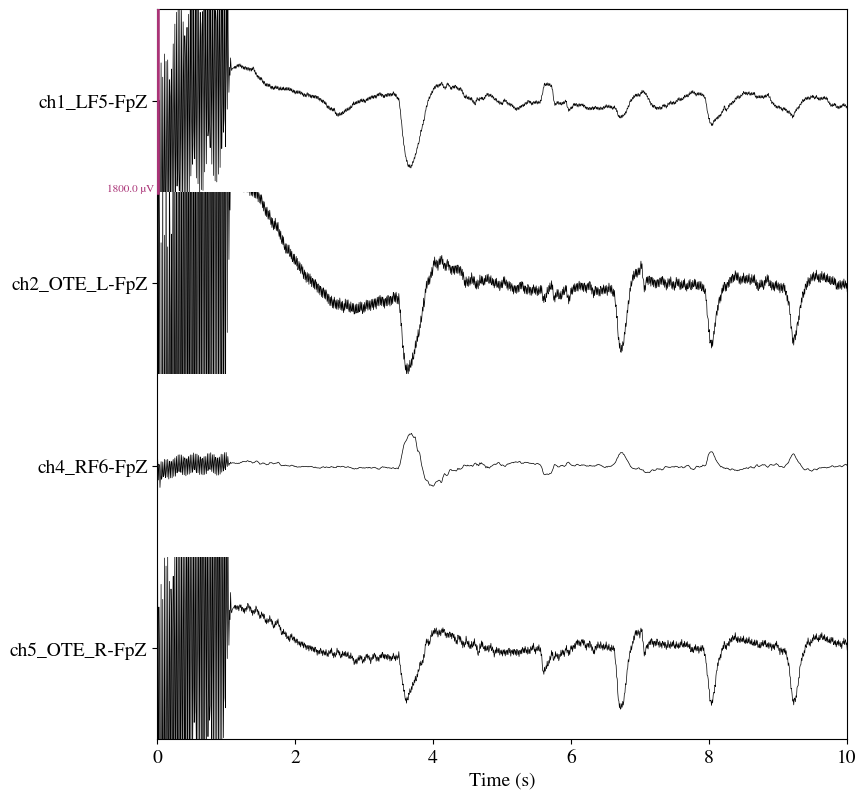

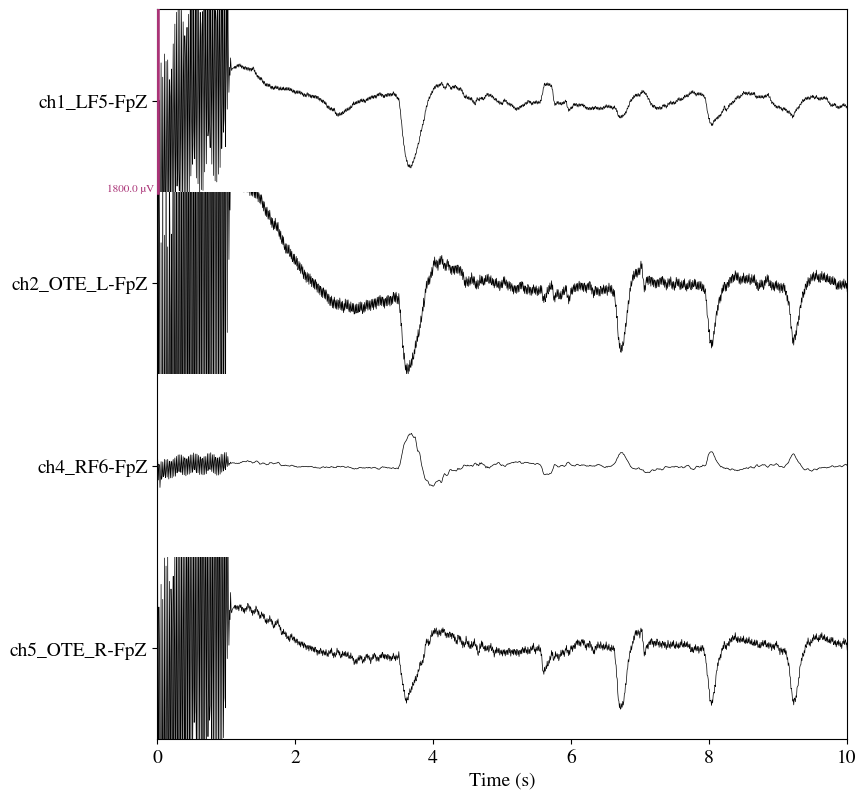

In [68]:
data1.plot( scalings='0.0009', clipping=0.5, remove_dc=True, lowpass =60, show_scrollbars=False, filtorder = 20, theme='auto')

In [69]:
EEG_raw_data  = data1.get_data()
SCALE=1e5 ## sclaed by 100000
raw_data= EEG_raw_data*SCALE

In [70]:
raw_data.shape

(4, 152875)

In [71]:
def non_neg_val(eeg_raw: np.ndarray)-> list:
    min_val = abs(eeg_raw.min())
    non_neg_val =[]
    for val in eeg_raw:
        val +=min_val
        non_neg_val.append(val)
    return non_neg_val
        

In [72]:
def parameter_estimation(non_neg_val: list) -> tuple:
    np_non_neg_val = np.array(non_neg_val)
    k_min = math.floor(math.log2((2/3) * (np_non_neg_val.mean()+ 1)))
    k_max = math.ceil(math.log2(np_non_neg_val.mean()))
    numerator  = math.log10( (math.sqrt(5)+1)/2 -1)
    denominator = math.log10(np_non_neg_val.mean() / (np_non_neg_val.mean()+1))
    k_geo  =  1 + math.floor(math.log2(numerator/denominator))
    
    return k_min, k_max, k_geo

In [73]:
test_1 = non_neg_val(raw_data[0])
parameter  = parameter_estimation(test_1)
parameter

(10, 12, 11)

In [74]:
def compressed_file_size(data:list, parameter: str ) ->float:
    file_name = 'code_filter_words_channel_1_'+ parameter+'.txt'
    with open(file_name, 'w') as file:
            for val in data:
                file.write(val + "\n")
                

In [75]:
def compression_ratio(data:np.ndarray, raw_file_size:float) -> float:
    non_neg_data =  non_neg_val(data)
    parameters = parameter_estimation(non_neg_data)
    
    non_neg_int_data = []
    for val in non_neg_data:
        non_neg_data.append(int(val))
    
    

In [76]:
import numpy as np
import math
import os

def compression_ratio(eeg_raw: np.ndarray, raw_file_size: float) -> None:
    min_val = abs(eeg_raw.min())
    non_neg_val = eeg_raw + min_val + 1
    
    np_non_neg_val = np.array(non_neg_val)
    k_min = math.floor(math.log2((2/3) * (np_non_neg_val.mean() + 1)))
    k_max = math.ceil(math.log2(np_non_neg_val.mean()))
    numerator = math.log10((math.sqrt(5) + 1) / 2 - 1)
    denominator = np.log10(np_non_neg_val.mean() / (np_non_neg_val.mean() + 1))
    k_geo = 1 + math.floor(math.log2(numerator / denominator))
    
    k_dict = {'k_min': k_min, 'k_max': k_max, 'k_geo': k_geo}
    
    non_neg_int_val = [int(val) for val in non_neg_val]
    print(k_dict)
    
    k_val = [9, 13]
    
    for y in k_val:
        temp_code_words = [encode(val, y) for val in non_neg_int_val]
        file_name = f'code_filter_words_channel_other_{y}.txt'
        with open(file_name, 'w') as file:
            for val in temp_code_words:
                file.write(val + "\n")
        temp_code_words = []
        
    for y in k_val:
        file_name = f'code_filter_words_channel_other_{y}.txt'
        file_size = os.path.getsize(file_name)
        print(f'the file size of the {y} is {file_size}')
        print(f'the compression ratio for {y} is {file_size / raw_file_size}')

In [77]:
raw_data[0]

array([  174.77105684,    49.08223615,  -157.36316982, ...,
       -1644.52908324, -1596.63678502, -1532.42619184])

In [78]:
with open('raw_fileter_channel_1.txt', 'w') as file:
    for val in raw_data[0]:
        file.write(str(val) + "\n")

## filetered compression 
channel 1

In [79]:
raw_channel_1_size = os.path.getsize('raw_fileter_channel_1.txt')
raw_channel_1_size 

2919851

In [80]:
raw_data[0].min()

-2590.003503135729

In [81]:
compression_ratio(raw_data[0], raw_channel_1_size)

{'k_min': 10, 'k_max': 12, 'k_geo': 11}
the file size of the 9 is 2443161
the compression ratio for 9 is 0.836741669352306
the file size of the 13 is 2293125
the compression ratio for 13 is 0.7853568555381765


channel 2

In [82]:
with open('raw_fileter_channel_2.txt', 'w') as file:
    for val in raw_data[1]:
        file.write(str(val) + "\n")

In [83]:
raw_channel_2_size = os.path.getsize('raw_fileter_channel_2.txt')
raw_channel_2_size 

2900280

In [84]:
compression_ratio(raw_data[1], raw_channel_1_size)

{'k_min': 10, 'k_max': 12, 'k_geo': 11}
the file size of the 9 is 2433286
the compression ratio for 9 is 0.833359647461463
the file size of the 13 is 2293125
the compression ratio for 13 is 0.7853568555381765


channel 3

In [85]:
with open('raw_fileter_channel_3.txt', 'w') as file:
    for val in raw_data[2]:
        file.write(str(val) + "\n")

In [86]:
raw_channel_3_size = os.path.getsize('raw_fileter_channel_3.txt')
raw_channel_3_size 

2968769

In [87]:
compression_ratio(raw_data[2], raw_channel_3_size)

{'k_min': 10, 'k_max': 12, 'k_geo': 11}


the file size of the 9 is 2444619
the compression ratio for 9 is 0.8234453404761367
the file size of the 13 is 2293125
the compression ratio for 13 is 0.7724161091684802


channel 4

In [88]:
raw_data[3]

array([  288.03688487,    48.99690657,  -237.60792438, ...,
       -1643.88634726, -1595.94158366, -1531.73663081])

In [89]:
with open('raw_fileter_channel_last.txt', 'w') as file:
    for val in raw_data[3]:
        file.write(str(val) + "\n")

In [90]:
raw_channel_4_size = os.path.getsize('raw_fileter_channel_last.txt')
raw_channel_4_size 

2911998

In [91]:
compression_ratio(raw_data[3], raw_channel_4_size)

{'k_min': 10, 'k_max': 12, 'k_geo': 11}


the file size of the 9 is 2429785
the compression ratio for 9 is 0.8344047626406337
the file size of the 13 is 2293125
the compression ratio for 13 is 0.7874747853535614


channel wise average

In [92]:
##K_min
'''k_min channel wise average'''
k_min_average = (0.7330332951921177 +  0.7330308978095115 + 0.7209611121646716 + 0.7350108070129169)/4
k_max_average = (0.7330247331113814 + 0.7330154860641862 + 0.7209479754066416 + 0.7349956971124293)/4
k_avg_average = (0.7329031515649257 + 0.7328969868667956 + 0.7208388392630076 + 0.7348590211943827)/4

k_min_average, k_max_average,  k_avg_average

(0.7305090280448044, 0.7304959729236595, 0.730374499722278)

the convex graph showing that there exist a local minima

In [93]:
compression_ratio(raw_data[2], raw_channel_3_size)

{'k_min': 10, 'k_max': 12, 'k_geo': 11}


the file size of the 9 is 2444619
the compression ratio for 9 is 0.8234453404761367
the file size of the 13 is 2293125
the compression ratio for 13 is 0.7724161091684802


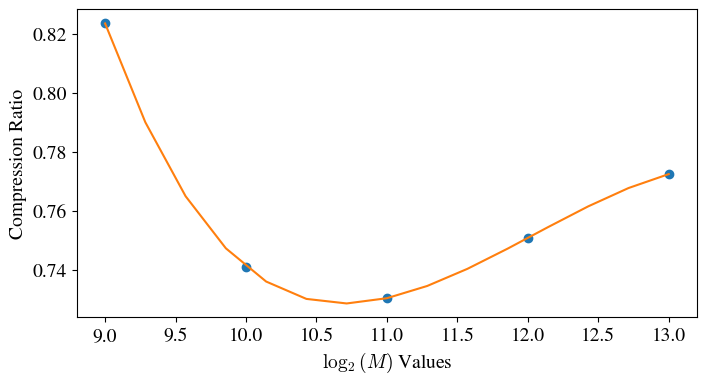

In [94]:
k_vals = np.array([9, 10, 11, 12, 13])
code_rate = np.array([0.82344534, 0.74090902, 0.73037449, 0.7507959, 0.77241610916])
code_rate_spline = make_interp_spline(k_vals, code_rate)
k_vals_2= np.linspace(k_vals.min(), k_vals.max(),15)

code_rate_spline_values = code_rate_spline(k_vals_2)

plt.figure(figsize=(8, 4))
plt.plot(k_vals, code_rate, 'o')
plt.plot(k_vals_2, code_rate_spline_values)
plt.xlabel(r'$\log_2(M) $ Values')
plt.ylabel('Compression Ratio')
plt.savefig('eeg_convex_curve.pdf', bbox_inches='tight')

In [95]:
def compression_ratio(eeg_raw: np.ndarray,  y) -> None:
    min_val = abs(eeg_raw.min())
    non_neg_val = eeg_raw + min_val + 1
    
    np_non_neg_val = np.array(non_neg_val)
    k_min = math.floor(math.log2((2/3) * (np_non_neg_val.mean() + 1)))
    k_max = math.ceil(math.log2(np_non_neg_val.mean()))
    numerator = math.log10((math.sqrt(5) + 1) / 2 - 1)
    denominator = np.log10(np_non_neg_val.mean() / (np_non_neg_val.mean() + 1))
    k_geo = 1 + math.floor(math.log2(numerator / denominator))
    
    k_dict = {'k_min': k_min, 'k_max': k_max, 'k_geo': k_geo}
    
    non_neg_int_val = [int(val) for val in non_neg_val]
    
    temp_code_words = [encode(val, y) for val in non_neg_int_val]
    # print(k_dict)
    
    # k_val = [9, 13]
    
    # for y in k_val:
        
    #     file_name = f'code_filter_words_channel_other_{y}.txt'
    #     with open(file_name, 'w') as file:
    #         for val in temp_code_words:
    #             file.write(val + "\n")
    #     temp_code_words = []
        
    # for y in k_val:
    #     file_name = f'code_filter_words_channel_other_{y}.txt'
    #     file_size = os.path.getsize(file_name)
    #     print(f'the file size of the {y} is {file_size}')
    #     print(f'the compression ratio for {y} is {file_size / raw_file_size}')

In [96]:
%timeit compression_ratio(raw_data[0], 11)
%timeit compression_ratio(raw_data[1], 11)
%timeit compression_ratio(raw_data[2], 11)
%timeit compression_ratio(raw_data[3], 11)

40.2 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.7 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.6 ms ± 871 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
